Identifiers & Metadata (mostly CRSP)

permno — Permanent security identifier in CRSP (unique to a stock/security).

permco — Permanent company identifier in CRSP (a company can have multiple permnos if multiple share classes).

date — Observation date.

nameendt — Name end date (last valid date for company name).

shrcd — CRSP share code (10 = common stock, etc.).

exchcd — CRSP exchange code (1 = NYSE, 2 = AMEX, 3 = NASDAQ).

siccd — Standard Industrial Classification (SIC).

naics — North American Industry Classification System (NAICS).

ncusip — 8-digit CRSP CUSIP.

cusip — Full CUSIP (sometimes 9-digit with check digit).

cusip_right — CUSIP for rights issues.

ticker / TICKER / tsymbol — Ticker symbol (duplicate naming).

comnam — Company name.

shrcls — Share class.

primexch — Primary exchange.

trdstat — Trading status (active/inactive).

secstat — Security status (equity/debt/etc.).

issuno — Issue number in CRSP.

hexcd, hsiccd, hsicmg, hsicig — Industry/exchange codes used by CRSP.

nmsind — NASDAQ National Market System indicator.

nsdinx — NASDAQ index membership.

gvkey — Compustat firm identifier (cross-link key).

adate, qdate — Accounting/report dates aligned to CRSP.

Corporate Actions / Delisting (CRSP)

dclrdt — Dividend declared date.

dlpdt — Delisting date.

dlstcd — Delisting code.

nextdt — Next dividend date.

paydt — Dividend payment date.

rcrddt — Record date for dividend.

shrflg — Share adjustment flag.

distcd — Distribution code.

divamt — Dividend amount.

dlret — Delisting return.

dlretx — Delisting return (excess).

dlprc — Delisting price.

Price & Return Data (CRSP)

prc — Closing price.

altprc — Alternative price field.

altprcdt — Date associated with altprc.

ret — Return (including distributions).

retx — Return (excluding distributions).

vwretd, vwretx — CRSP value-weighted index returns (with/without dividends).

ewretd, ewretx — CRSP equal-weighted index returns (with/without dividends).

sprtrn — S&P 500 return.

vol — Trading volume.

bid, ask — Closing bid/ask quotes.

bidlo, askhi — Bid low, ask high.

spread — Bid–ask spread.

Shares Outstanding & Adjustments (CRSP)

shrout — Shares outstanding (in thousands).

cfacpr — Cumulative factor to adjust price.

cfacshr — Cumulative factor to adjust shares.

facpr, facshr — Adjustment factors (for splits, dividends).

acperm, accomp — Accounting adjustment identifiers.

shrenddt — End date for share record.

nwperm — New permno (after permno change).

Valuation Ratios (Compustat / Derived)

bm — Book-to-market ratio.

evm — Enterprise value to market cap.

pe_op_basic, pe_op_dil, pe_exi, pe_inc — P/E ratios with different earnings definitions (basic, diluted, excluding extraordinary items, incl. extraordinary).

ps — Price-to-sales.

pcf — Price-to-cash-flow.

ptb — Price-to-book.

PEG_trailing — Price/earnings-to-growth (trailing).

divyield — Dividend yield.

CAPEI — Cyclically adjusted P/E (Shiller P/E).

Profitability Ratios

dpr — Dividend payout ratio.

npm — Net profit margin.

opmbd / opmad — Operating profit margins (before/after depreciation).

gpm — Gross profit margin.

ptpm — Pre-tax profit margin.

cfm — Cash flow margin.

roa — Return on assets.

roe — Return on equity.

roce — Return on capital employed.

efftax — Effective tax rate.

GProf — Gross profitability (à la Novy-Marx).

Investment & Growth Metrics

aftret_eq, aftret_invcapx, aftret_equity — After-tax returns on equity/capital.

pretret_noa — Pretax return on net operating assets.

pretret_earnat — Pretax return on earnings/assets.

equity_invcap — Equity share of invested capital.

debt_invcap, totdebt_invcap — Debt share of invested capital (short + long).

capital_ratio — Capitalization ratio.

sale_invcap — Sales to invested capital.

sale_equity — Sales to equity.

sale_nwc — Sales to net working capital.

rd_sale — R&D to sales.

adv_sale — Advertising to sales.

staff_sale — Staff expenses to sales.

Leverage & Debt

int_debt — Interest-bearing debt.

int_totdebt — Interest-bearing / total debt.

cash_lt — Cash to total liabilities.

invt_act — Inventory to assets.

rect_act — Receivables to assets.

debt_at — Debt-to-assets.

debt_ebitda — Debt-to-EBITDA.

short_debt — Short-term debt.

curr_debt — Current portion of debt.

lt_debt — Long-term debt.

dltt_be — Long-term debt to book equity.

debt_assets — Debt-to-assets.

debt_capital — Debt-to-capital.

de_ratio — Debt-to-equity.

intcov — Interest coverage.

intcov_ratio — Interest coverage ratio.

Liquidity Ratios

cash_ratio — Cash/current liabilities.

quick_ratio — (Cash + receivables)/current liabilities.

curr_ratio — Current assets/current liabilities.

cash_conversion — Cash conversion cycle.

inv_turn — Inventory turnover.

at_turn — Asset turnover.

rect_turn — Receivables turnover.

pay_turn — Payables turnover.

Cash Flow Metrics

profit_lct — Profitability relative to current liabilities.

ocf_lct — Operating cash flow to current liabilities.

cash_debt — Cash flow to debt.

fcf_ocf — Free cash flow to operating cash flow.

lt_ppent — Long-term PP&E.

Accruals & Quality

accrual — Accruals ratio (earnings quality measure).

In [2]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import os
import tqdm

import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp

In [7]:
class FactorModel:
    """
    A class to handle data loading, factor calculation, portfolio formation, and
    backtesting against factor models.
    """

    def __init__(self, start: str, end: str):
        """
        Initializes the DataWrapper with data parameters.

        Args:
            start (str): The start date for the data in 'YYYY-MM-DD' format.
            end (str): The end date for the data in 'YYYY-MM-DD' format.
        """
        self.start = datetime.datetime.strptime(start, "%Y-%m-%d")
        self.end = datetime.datetime.strptime(end, "%Y-%m-%d")
        self.load_data()
        self.calculate_factors()

    def load_data(self) -> pl.DataFrame:
        """
        Returns:
            pl.DataFrame: A Polars DataFrame containing filtered & sorted risk data.
        """
        # read in & format compustat data
        compustat = pl.read_csv("compustat_na.csv", null_values=[''], ignore_errors=True)
        compustat = compustat.with_columns(pl.col(["adate", "qdate", "public_date"]).str.to_date(format="%Y-%m-%d"))
        compustat = compustat.rename({"public_date": "date"}) # for mergings
        self.compustat = compustat

        # read in & format crsp data
        na_values=[chr(i) for i in range(65, 91)] + [f"{chr(i)}{chr(j)}" for i in range(65, 91) for j in range(65, 91)]
        crsp = pl.read_csv("crsp_data.csv", null_values=na_values, ignore_errors=True)
        crsp = crsp.with_columns(pl.col(["ALTPRCDT", "date"]).str.to_date(format="%Y-%m-%d"))
        crsp.columns = [col.lower() for col in crsp.columns]
        self.crsp = crsp

        # combine dataframes
        data = crsp.join(
            compustat,
            on=["permno", "date"],
            how="inner"
        )

        # sort & filter data
        data = (
            data.sort('permno', 'date')
            .filter([
                pl.col('date').is_between(self.start, self.end), # desired date range
                pl.col('prc').gt(5) # prices > 5
            ])
            .unique(['permno', 'date'], keep='last') # remove duplicates
        )

        self.data = data

    def calculate_factors(self):
        """
        Calculates factors and adds them as new columns to the dataframe.
        """
        # Ensure data is loaded
        if self.data is None:
            raise ValueError("Data has not been loaded. Please run load_data() first.")

        # Filter for common stocks from major exchanges
        self.data = self.data.filter(
            pl.col('shrcd').is_in([10, 11]) &
            pl.col('exchcd').is_in([1, 2, 3])
        )

        window_size = 12
        self.data = self.data.with_columns([
        # 1. market risk: beta = cov(asset, market) / var(market)
        (
            pl.rolling_cov("vwretd", "ret", window_size=window_size) /
            pl.col("vwretd").rolling_var(window_size=window_size)
        ).over("permno").alias("beta"),

            # 2. size: 1 / log(market cap)
            (1 / (pl.col("prc").abs() * pl.col("shrout") / 1000).log()).alias("size"),
            
            # get total investment capital (proxy for total assets)
            (pl.col("equity_invcap") + pl.col("debt_invcap")).alias("invcap"),

        ]).with_columns([
            # 3. investment: invested capital growth
            ((pl.col("invcap") / pl.col("invcap").shift(12).over("permno")) - 1).alias("investment"),

            # 4. momentum: 12-month momentum, skipping the most recent month
            ((pl.col("prc").shift(1).over("permno") / pl.col("prc").shift(12).over("permno")) - 1).alias("mom12m"),
        ])

        # 5. value: bm (already in data)
        """        
        self.data = self.data.with_columns(
            (1 / pl.col("bm"))
            .log()
            .alias("bm")
        )
        """
        # 6. profitability: GProf (already in data)

        

    def form_factor_portfolios(
        self,
        factor_columns: list[str],
        quantiles: int = 10,
        rebal_freq: str = "1mo"
    ) -> pl.DataFrame:
        """
        Forms portfolios by sorting stocks on specified factors and calculates their subsequent returns.
        (Revised to handle non-unique quantiles)
        """
        # validate that columns are actually in dataframe
        missing_cols = [col for col in factor_columns if col not in self.data.columns]
        if missing_cols:
            raise ValueError(f"Factor columns not found in data: {missing_cols}")

        # drop columns with null values
        self.data = self.data.drop_nulls(subset=factor_columns)

        # get forward return
        data_with_fwd_ret = self.data.with_columns(
            pl.col("ret").shift(-1).over("permno").alias("fwd_ret")
        ).drop_nulls("fwd_ret")

        # find rebalance dates
        rebal_dates = (
            data_with_fwd_ret.group_by(
                pl.col("date").dt.truncate(rebal_freq).alias("grouping_date")
            )
            .agg(
                pl.col("date").max()
            )
            .sort("grouping_date")["date"]
            .to_list()
        )

        # form portfolios based on ranking
        all_portfolios_list = []
        for factor in factor_columns:
            quantile_labels = [f"Q{i+1}" for i in range(quantiles)]
            
            ranked_data = (
                data_with_fwd_ret.filter(pl.col("date").is_in(rebal_dates))
                .with_columns(
                    pl.col(factor)
                    .qcut(quantiles, labels=quantile_labels, allow_duplicates=True)
                    .over("date")
                    .alias("quantile")
                )
            )

            quantile_returns = (
                ranked_data.group_by(["date", "quantile"])
                .agg(pl.mean("fwd_ret").alias("portfolio_ret"))
            )
            
            top_q_returns = quantile_returns.filter(pl.col("quantile") == f"Q{quantiles}")
            bottom_q_returns = quantile_returns.filter(pl.col("quantile") == "Q1")

            long_short_df = top_q_returns.join(
                bottom_q_returns, on="date", suffix="_bottom"
            )

            long_short_returns = long_short_df.with_columns(
                (pl.col("portfolio_ret") - pl.col("portfolio_ret_bottom")).alias("portfolio_ret"),
                pl.lit("Long_Short").alias("quantile")
            ).select(["date", "quantile", "portfolio_ret"])

            final_factor_returns = pl.concat([
                quantile_returns.with_columns(pl.col("quantile").cast(pl.String)),
                long_short_returns
            ]).with_columns(
                pl.lit(factor).alias("factor")
            )
            
            all_portfolios_list.append(final_factor_returns)

        return pl.concat(all_portfolios_list).select(
            ["date", "factor", "quantile", "portfolio_ret"]
        ).sort(["factor", "quantile", "date"])


    def calculate_performance_stats(
        self, 
        portfolio_returns: pl.DataFrame, 
        periods_per_year: int = 12
    ) -> pl.DataFrame:
        """Calculates performance statistics for each portfolio from a single DataFrame."""
        stats = portfolio_returns.group_by(["factor", "quantile"]).agg([
            (pl.col("portfolio_ret") + 1).product().sub(1).alias("Cumulative Return"),
            
            # Updated from pl.len() to pl.count()
            (((pl.col("portfolio_ret") + 1).product() ** (periods_per_year / pl.len())) - 1)
            .alias("Annualized Return"),

            (pl.col("portfolio_ret").std() * (periods_per_year**0.5))
            .alias("Annualized Volatility")
        ]).with_columns(
            (pl.col("Annualized Return") / pl.col("Annualized Volatility"))
            .alias("Sharpe Ratio")
        ).sort(["factor", "quantile"])
        
        return stats.rename({"factor": "Factor", "quantile": "Portfolio"})


    def plot_cumulative_returns(self, portfolio_returns: pl.DataFrame, title: str = "Factor Portfolio Cumulative Returns"):
        """
        Plots the cumulative returns (growth of $1) for factor portfolios over time.

        Args:
            portfolio_returns (pl.DataFrame): The tidy DataFrame from form_factor_portfolios.
            title (str): The main title for the plot.
        """
        # Calculate cumulative returns for each portfolio
        plot_data = portfolio_returns.with_columns(
            (1 + pl.col("portfolio_ret")).cum_prod().over(["factor", "quantile"]).alias("cumulative_return")
        )

        # Create a facet grid to plot each factor on its own subplot
        g = sns.FacetGrid(plot_data.to_pandas(), col="factor", col_wrap=2, hue="quantile", height=4, aspect=1.5, sharey=False)
        g.map(sns.lineplot, "date", "cumulative_return", alpha=0.8)

        # Formatting
        g.fig.suptitle(title, y=1.02, fontsize=16)
        g.set_axis_labels("Date", "Growth of $1")
        g.set_titles("Factor: {col_name}")
        g.add_legend(title='Portfolio')
        
        plt.tight_layout()
        plt.show()


    def plot_performance_summary(self, performance_summary: pl.DataFrame, metric: str = "Sharpe Ratio"):
        """
        Creates bar plots to compare a specific performance metric across portfolios.

        Args:
            performance_summary (pl.DataFrame): The DataFrame from calculate_performance_stats.
            metric (str): The metric to plot (e.g., "Sharpe Ratio", "Annualized Return").
        """
        if metric not in performance_summary.columns:
            raise ValueError(f"Metric '{metric}' not found. Available metrics are: {performance_summary.columns}")

        # Create a bar plot for each factor
        g = sns.catplot(
            data=performance_summary.to_pandas(),
            x="Portfolio",
            y=metric,
            col="Factor",
            kind="bar",
            height=4,
            aspect=1.2,
            sharey=False,
            palette="viridis",
            hue="Portfolio",
            legend=False
        )

        # Formatting
        g.fig.suptitle(f"Performance Summary: {metric}", y=1.02, fontsize=16)
        g.set_axis_labels("Portfolio", metric)
        g.set_titles("Factor: {col_name}")
        g.set_xticklabels(rotation=45)

        plt.tight_layout()
        plt.show()


    def plot_combined_portfolio(self, portfolio_returns: pl.DataFrame, title: str = "Combined Multi-Factor Portfolio vs. Individual Factors"):
        """
        Plots a combined, equal-weighted multi-factor portfolio against the individual
        long-short factor portfolios.
        """
        # 1. Isolate the return series for each individual long-short portfolio
        long_short_returns = portfolio_returns.filter(
            pl.col("quantile") == "Long_Short"
        )

        # 2. Create the combined portfolio by averaging the long-short returns each day
        combined_ew_returns = long_short_returns.group_by("date").agg(
            pl.mean("portfolio_ret").alias("portfolio_ret")
        ).with_columns(
            pl.lit("Combined_EW").alias("factor")  # Name this new strategy
        ).sort("date")
        
        # --- THIS BLOCK IS THE FIX ---
        # 3. Combine them, ensuring both have the same column order
        plot_data_source = pl.concat([
            long_short_returns.select(["date", "factor", "portfolio_ret"]),
            combined_ew_returns.select(["date", "factor", "portfolio_ret"]) # Enforce column order here
        ])
        # --- END OF FIX ---
        
        # 4. Calculate the cumulative returns ("growth of $1") for all portfolios
        plot_data = plot_data_source.with_columns(
            (1 + pl.col("portfolio_ret")).cum_prod().over("factor").alias("cumulative_return")
        )

        # 5. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 8))
        
        ax = sns.lineplot(
            data=plot_data.to_pandas(), 
            x='date', 
            y='cumulative_return', 
            hue='factor', 
            linewidth=2.5
        )
        
        # Make the 'Combined_EW' line stand out
        for line in ax.lines:
            if line.get_label() == 'Combined_EW':
                line.set_linewidth(4)
                line.set_linestyle('--')
                line.set_color('black')

        # Formatting
        ax.set_title(title, fontsize=18, weight='bold')
        ax.set_xlabel("Date", fontsize=12)
        ax.set_ylabel("Growth of $1 (Log Scale)", fontsize=12)
        ax.set_yscale('log')
        ax.legend(title='Factor Strategy')
        plt.tight_layout()
        plt.show()
        
    def run_and_analyze(
            self,
            factor_columns: list[str],
            quantiles: int = 5,
            rebal_freq: str = "1mo"
        ):
        """
        Runs the full factor analysis pipeline.
        """
        print("--- Starting Factor Analysis ---")

        # Step 1: Form portfolios
        print(f"Step 1/4: Forming portfolios for factors: {factor_columns}...")
        all_returns = self.form_factor_portfolios(
            factor_columns=factor_columns,
            quantiles=quantiles,
            rebal_freq=rebal_freq
        )
        print("Done.")

        # Step 2: Calculate performance statistics
        print("Step 2/4: Calculating performance statistics...")
        periods_per_year = 12 if rebal_freq == "1mo" else 4 if rebal_freq == "1q" else 1
        performance_summary = self.calculate_performance_stats(
            all_returns,
            periods_per_year=periods_per_year
        )
        print("Done.")

        # Step 3: Print summary
        print("Step 3/4: Printing summary...")
        print("\n" + "="*25)
        print("  Performance Summary")
        print("="*25)
        print(performance_summary)
        print("="*25 + "\n")

        # Step 4: Generate plots
        print("Step 4/4: Generating plots...")
        # Plot 1: The new combined portfolio chart
        self.plot_combined_portfolio(all_returns)
        # Plot 2: The original individual factor charts
        self.plot_cumulative_returns(all_returns)
        # Plot 3 & 4: The summary bar charts
        self.plot_performance_summary(performance_summary, metric="Sharpe Ratio")
        self.plot_performance_summary(performance_summary, metric="Annualized Return")
        
        print("--- Analysis Complete ---")

        return all_returns, performance_summary

--- Starting Factor Analysis ---
Step 1/4: Forming portfolios for factors: ['beta', 'bm', 'mom12m', 'size']...
Done.
Step 2/4: Calculating performance statistics...
Done.
Step 3/4: Printing summary...

  Performance Summary
shape: (44, 6)
┌────────┬────────────┬───────────────────┬───────────────────┬────────────┬──────────────┐
│ Factor ┆ Portfolio  ┆ Cumulative Return ┆ Annualized Return ┆ Annualized ┆ Sharpe Ratio │
│ ---    ┆ ---        ┆ ---               ┆ ---               ┆ Volatility ┆ ---          │
│ str    ┆ str        ┆ f64               ┆ f64               ┆ ---        ┆ f64          │
│        ┆            ┆                   ┆                   ┆ f64        ┆              │
╞════════╪════════════╪═══════════════════╪═══════════════════╪════════════╪══════════════╡
│ beta   ┆ Long_Short ┆ 0.003581          ┆ 0.000505          ┆ 0.067324   ┆ 0.007498     │
│ beta   ┆ Q1         ┆ 2.924983          ┆ 0.212931          ┆ 0.04235    ┆ 5.027924     │
│ beta   ┆ Q10        ┆ 2

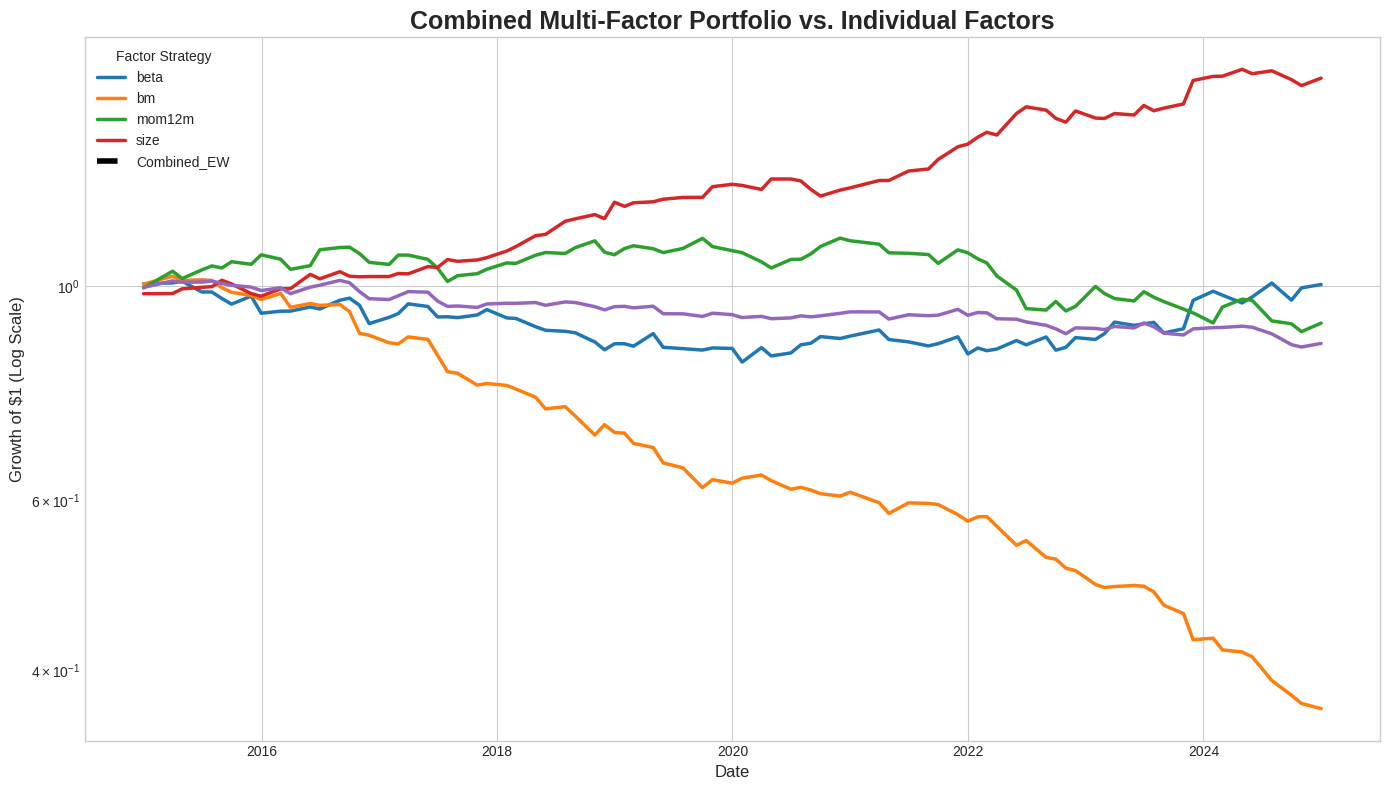

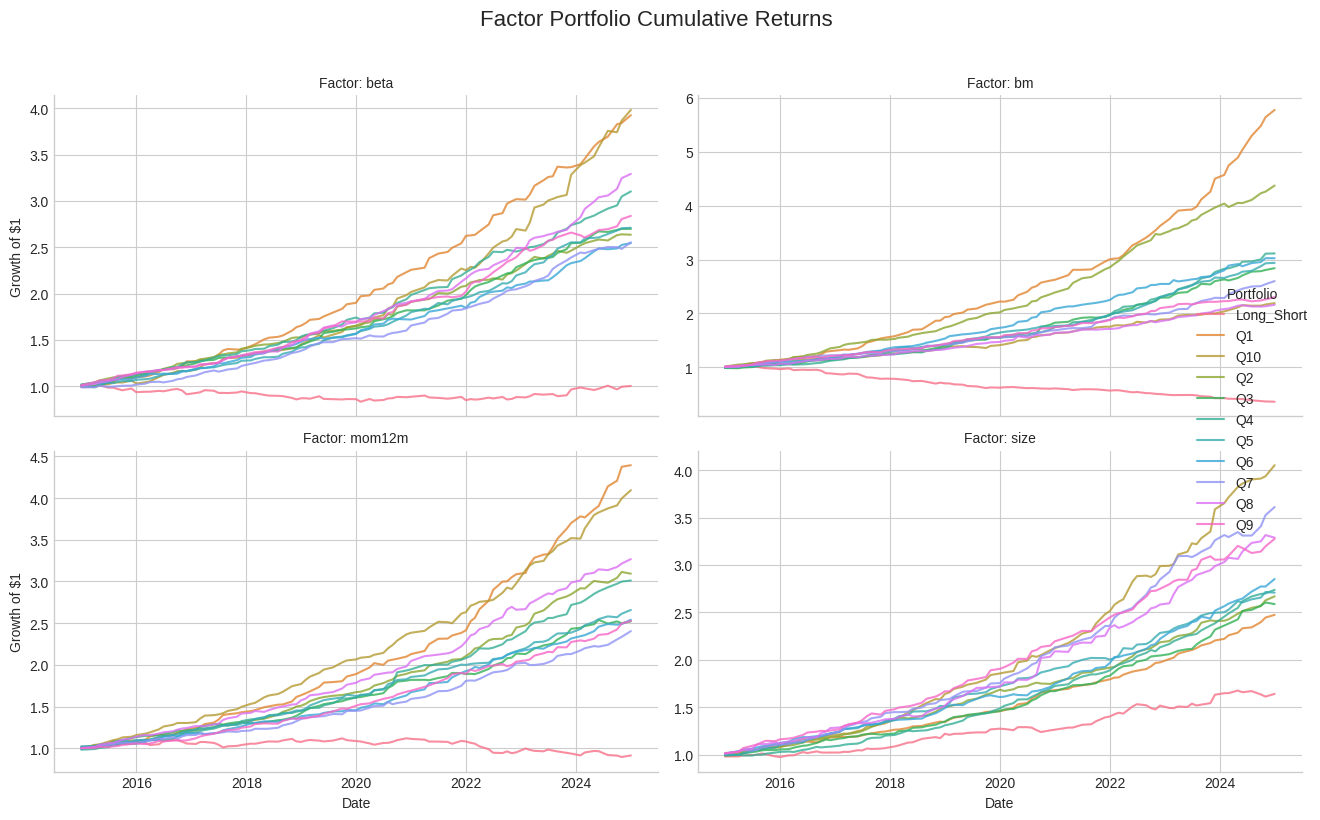

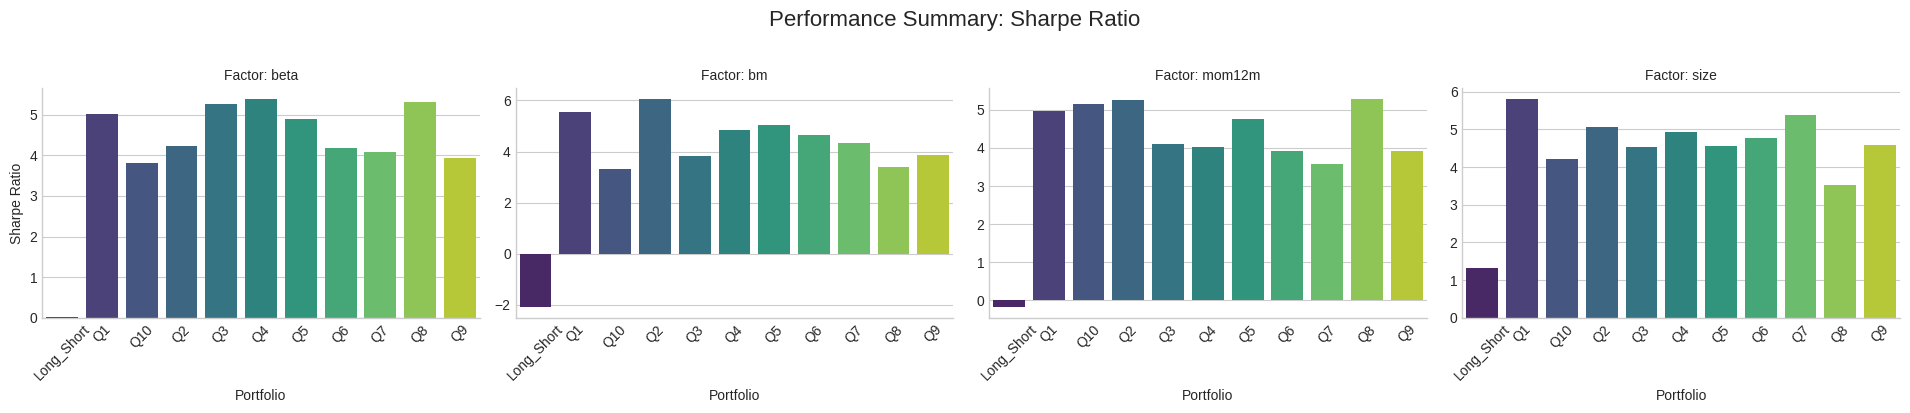

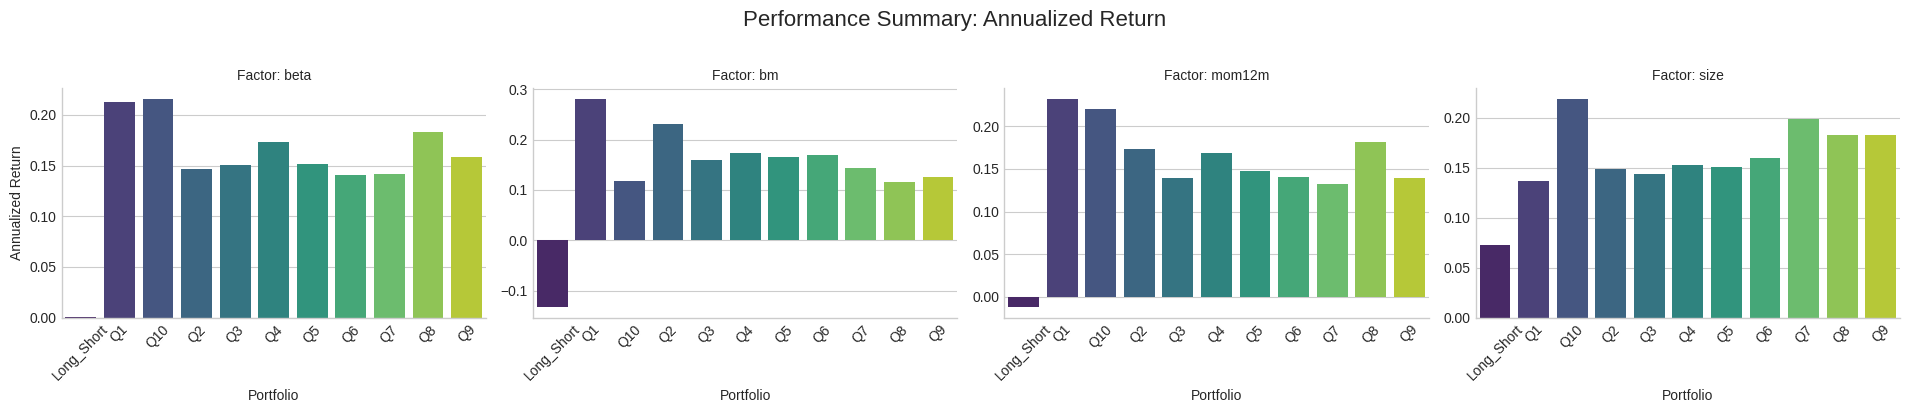

--- Analysis Complete ---

Returned Summary Stats DataFrame:
shape: (44, 6)
┌────────┬────────────┬───────────────────┬───────────────────┬────────────┬──────────────┐
│ Factor ┆ Portfolio  ┆ Cumulative Return ┆ Annualized Return ┆ Annualized ┆ Sharpe Ratio │
│ ---    ┆ ---        ┆ ---               ┆ ---               ┆ Volatility ┆ ---          │
│ str    ┆ str        ┆ f64               ┆ f64               ┆ ---        ┆ f64          │
│        ┆            ┆                   ┆                   ┆ f64        ┆              │
╞════════╪════════════╪═══════════════════╪═══════════════════╪════════════╪══════════════╡
│ beta   ┆ Long_Short ┆ 0.003581          ┆ 0.000505          ┆ 0.067324   ┆ 0.007498     │
│ beta   ┆ Q1         ┆ 2.924983          ┆ 0.212931          ┆ 0.04235    ┆ 5.027924     │
│ beta   ┆ Q10        ┆ 2.981892          ┆ 0.215398          ┆ 0.056519   ┆ 3.811044     │
│ beta   ┆ Q2         ┆ 1.635495          ┆ 0.14661           ┆ 0.034659   ┆ 4.230128     │
│ be

In [ ]:
# 1. Initialize the model with your desired date range
model = FactorModel(start="2014-12-31", end="2024-12-31")
carhart4_columns = ["beta", "bm", "mom12m", "size"] # market risk, vaulue, momentum, size
columns = ["size"]

# 2. Run the entire analysis with a single command!
#    This will print the summary table and show all the plots.
returns_data, summary_stats = model.run_and_analyze(
    factor_columns=carhart4_columns,
    quantiles=10
)

# You still get the data back in case you want to do more custom analysis.
print("\nReturned Summary Stats DataFrame:")
print(summary_stats)